In [1]:
import sys
sys.path.append("..")
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from datasets import get_timeseries_bundle
from ad.models import GPT2ADModel
from fixer.models import MyTimeDiffusionModel
from fixer.time_repair import *
torch.cuda.set_device(1)


/home/antonxue/lib/miniconda3/envs/arpro/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
time_ds = get_timeseries_bundle(ds_name="swat", label_choice = 'all', shuffle=False, test_batch_size=16, train_has_only_goods=True)
train_dataloader = time_ds['train_dataloader'] 
test_dataloader = time_ds['test_dataloader'] 
for batch in test_dataloader:
    x, y, m  = batch
    m = m.long()
    if y.sum() != 0:
        break
np.where((m == 1).sum(dim=1).sum(dim=0) != 0)


loading cache from /home/antonxue/foo/data/swat/cache/swat_W100_Ctrain_Lall.cache
loading cache from /home/antonxue/foo/data/swat/cache/swat_W100_Ctest_Lall.cache


(array([2]),)

In [3]:
y.shape

torch.Size([16, 100])

In [4]:
path = "/home/antonxue/foo/arpro/_dump/fixer_ts_diffusion_swat_best.pt"
mytsdiff = MyTimeDiffusionModel(feature_dim=51, window_size=100)
model_dict = torch.load(path)['model_state_dict']
mytsdiff.load_state_dict(model_dict)
mytsdiff.cuda();


In [5]:
ad = GPT2ADModel()
path = '/home/antonxue/foo/arpro/_dump/ad_gpt2_swat_best.pt'
model_dict = torch.load(path)['model_state_dict']
ad.load_state_dict(model_dict)
ad.eval().cuda();

In [6]:
# ret = mytsdiff(x.cuda(), batch_size=32, progress_bar=True)
model_kwargs = {
    "coef": 1e-2,
    "learning_rate": 5e-2
}
m = 1-m
# ret = mytsdiff.repair(x.cuda(), (x*m).cuda(), m.long().cuda(), model_kwargs=model_kwargs, sampling_timesteps=500)

In [7]:
noise_level = 100
torch.autograd.set_detect_anomaly(True)
config = TimeRepairConfig(lr=1e-5, batch_size=16, guide_scale_end=0.1, prop1_scale=10.)
guided_ret = time_repair(x.cuda(), m.cuda(), ad, mytsdiff, config, noise_level)


100%|██████████| 100/100 [01:04<00:00,  1.55it/s]26.52, L2 2.46 0.25, L3 0.06 0.06, L4 0.01 0.01, : : 0it [01:04, ?it/s]
gs -1.00, avg_L 67.21, curr_L 39.35, L1 36.83 36826.52, L2 2.46 0.25, L3 0.06 0.06, L4 0.01 0.01, : : 0it [01:04, ?it/s]


In [ ]:
noise_level = 100
torch.autograd.set_detect_anomaly(True)
config = TimeRepairConfig(lr=1e-5, batch_size=16, guide_scale_end=0.1, prop1_scale=1.)
guided_ret = time_repair(x.cuda(), m.cuda(), ad, mytsdiff, config, noise_level)

In [12]:
guided_ret['x_fix'].shape

torch.Size([16, 100, 51])

In [8]:
def plot_ts(x, y, idx):
    x_to_plot = x[:, idx].detach().cpu()
    fig, ax1 = plt.subplots(figsize=(8, 4))

    # Plot x on the left y-axis
    ax1.plot(x_to_plot, marker='o', linestyle='-', color='blue', label='X Values')
    ax1.set_xlabel('Window Index')
    ax1.set_ylabel('X Values', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.grid(True)

    # Highlight anomalies
    for i, label in enumerate(y):
        if label == 1:
            ax1.axvspan(i-0.5, i+0.5, color='red', alpha=0.3)

    # Adding legends
    lines, labels = ax1.get_legend_handles_labels()
    ax1.legend(lines , labels, loc='upper left')

In [9]:
y[14]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1])

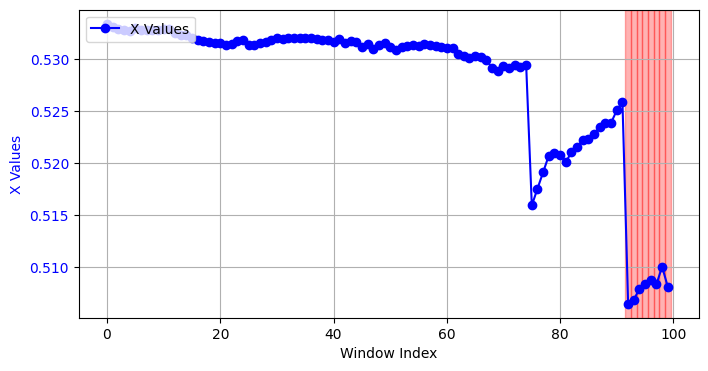

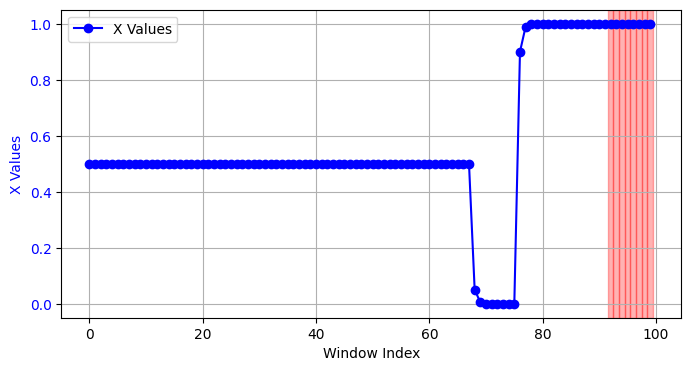

In [17]:
idx = 2
t = 14
plot_ts(guided_ret['x_fix'][t], y[t], idx)
plot_ts(x[t], y[t], idx)

In [ ]:
ap1d = nn.AvgPool1d(kernel_size=3, stride=1, padding=1)

In [ ]:
x.shape, ap1d(x).shape

In [ ]:
fftx = torch.fft.fft(x).cpu()
ffty = torch.fft.fft(ret).cpu()

In [ ]:
fftx.shape, ffty.shape, fftx.dtype

In [ ]:
(fftx - ffty).abs().dtype

In [ ]:
torch.norm(fftx.cpu() - ffty.cpu(), p=2) ** 2 / fftx.numel()

In [ ]:
torch.norm((fftx.cpu() - ffty.cpu)/fftx.numel().sqrt(), p=2) ** 2

In [ ]:
(fftx.cpu() - ffty.cpu()).abs().shape

In [ ]:
torch.view_as_real(fftx).shape

In [ ]:
y

In [ ]:
out = model(x.cuda())
x_recon = out.others['x_recon']
anomaly_criterion = nn.MSELoss(reduce=False)
score = torch.mean(anomaly_criterion(x.cuda(), x_recon), dim=-1)
score = score.detach().cpu().numpy()

In [ ]:
attens_energy = []
with torch.no_grad():
    for i, (batch_x, batch_y, batch_m) in enumerate(train_dataloader):
        batch_x = batch_x.float().cuda()
        # reconstruction
        outputs = model(batch_x)
        # criterion
        score = torch.mean(anomaly_criterion(batch_x, outputs.others['x_recon']), dim=-1)
        score = score.detach().cpu().numpy()
        attens_energy.append(score)

attens_energy = np.concatenate(attens_energy, axis=0).reshape(-1)
train_energy = np.array(attens_energy)

# (2) find the threshold
attens_energy = []
test_labels = []
for i, (batch_x, batch_y, batch_m) in enumerate(test_dataloader):
    batch_x = batch_x.float().cuda()
    # reconstruction
    outputs = model(batch_x)
    # criterion
    score = torch.mean(anomaly_criterion(batch_x, outputs.others['x_recon']), dim=-1)
    score = score.detach().cpu().numpy()
    attens_energy.append(score)
    test_labels.append(batch_y)
    break



In [ ]:
test_energy.reshape(-1).shape

In [ ]:
# attens_energy = np.concatenate(attens_energy, axis=0).reshape(-1)
test_energy = np.array(score)
combined_energy = np.concatenate([train_energy, test_energy.reshape(-1)], axis=0)
threshold = np.percentile(combined_energy, 80)
print("Threshold :", threshold)

# (3) evaluation on the test set
pred = (test_energy > threshold).astype(int)
# test_labels = np.concatenate(test_labels, axis=0).reshape(-1)
test_labels = np.array(test_labels)

In [ ]:
pred.shape

In [ ]:
idxs = np.where((m == 1).sum(dim=1).sum(dim=0) != 0)[0]
for idx in idxs:

    x_to_plot = x[:, -1, idx]
    score_to_plot = pred[:, -1]

    # Create the plot
    fig, ax1 = plt.subplots(figsize=(10, 5))

    # Plot x on the left y-axis
    ax1.plot(x_to_plot, marker='o', linestyle='-', color='blue', label='X Values')
    ax1.set_xlabel('Window Index')
    ax1.set_ylabel('X Values', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.grid(True)

    # Create a second y-axis for the score
    ax2 = ax1.twinx()
    ax2.plot(score_to_plot, marker='v', linestyle='-', color='green', label='Score')
    ax2.set_ylabel('Score', color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    # Highlight anomalies
    for i, label in enumerate(y):
        if label == 1:
            ax1.axvspan(i-0.5, i+0.5, color='red', alpha=0.3)

    # Adding legends
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left')

    # plt.title('Plot of X and Score with Anomalies Highlighted')
    plt.show()
    plt.close()

In [ ]:
score_to_plot

In [ ]:
x